## Задача 1

Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).

Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

In [437]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

### Сформируем с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками

In [438]:
# сгенерируем данные, представляющие собой 100 объектов с 2 признаками
classification_data, classification_labels = datasets.make_classification(n_samples=100,
                                                      n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=8)

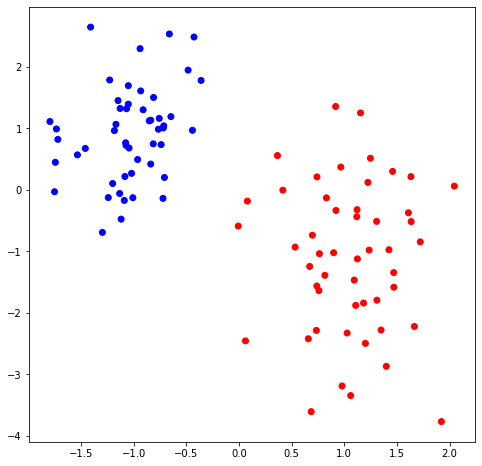

In [439]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

Реализуем генерацию $N$ бутстрап-выборок и подмножества признаков для нахождения разбиения в узле.

In [440]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        b_idx = np.zeros(labels.shape).astype(int)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
            b_idx[j] = sample_index
        bootstrap.append((b_data, b_labels, b_idx))
        
    return bootstrap

In [441]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

Далее повторим реализацию построения дерева решений из предыдущего урока с некоторыми изменениями

In [442]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [443]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [444]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [445]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [446]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [447]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [448]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

Теперь добавим функцию формирования случайного леса.

In [449]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    b_idx = set()
    
    for b_data, b_labels, b_indexes in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        b_idx = b_idx.union(b_indexes)
        
    return forest, b_idx

In [450]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [451]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [452]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

Далее мы сделаем обычное разбиение выборки на обучающую и тестовую, как это делалось ранее. Оценить ошибку этого же алгоритма по методу Out-of-Bag будет вашим домашним заданием к этому уроку.

In [453]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [454]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

Теперь построим несколько случайных лесов с разным количеством деревьев в них.

### Обучим случайный лес из 1, 3, 10 и 50 деревьев

In [455]:
n_trees = [1, 3, 10, 50]
n = len(n_trees)
my_forests = []
b_idx = []
for t in n_trees:
    my_forest, b_indexes = random_forest(train_data, train_labels, t)
    my_forests.append(my_forest)
    b_idx.append(b_indexes)

In [456]:
# Получим ответы для обучающей выборки 
train_answers = []
test_answers = []
train_accuracy = []
for forest in my_forests:
    train_answers.append(tree_vote(forest, train_data))
    test_answers.append(tree_vote(forest, test_data))

In [457]:
# Точность на обучающей выборке
train_accuracy = []
test_accuracy = []
for i in range(n):
    train_accuracy.append(accuracy_metric(train_labels, train_answers[i]))
    test_accuracy.append(accuracy_metric(test_labels, test_answers[i]))
    print(f'Точность случайного леса из {n_trees[i]} деревьев на обучающей выборке: {train_accuracy[i]:.3f}')
    print(f'Точность случайного леса из {n_trees[i]} деревьев на тестовой выборке: {test_accuracy[i]:.3f}')
    print('*'*60)

Точность случайного леса из 1 деревьев на обучающей выборке: 94.286
Точность случайного леса из 1 деревьев на тестовой выборке: 90.000
************************************************************
Точность случайного леса из 3 деревьев на обучающей выборке: 97.143
Точность случайного леса из 3 деревьев на тестовой выборке: 96.667
************************************************************
Точность случайного леса из 10 деревьев на обучающей выборке: 98.571
Точность случайного леса из 10 деревьев на тестовой выборке: 100.000
************************************************************
Точность случайного леса из 50 деревьев на обучающей выборке: 100.000
Точность случайного леса из 50 деревьев на тестовой выборке: 100.000
************************************************************


### Визуализируем их разделяющие гиперплоскости на графиках

In [458]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

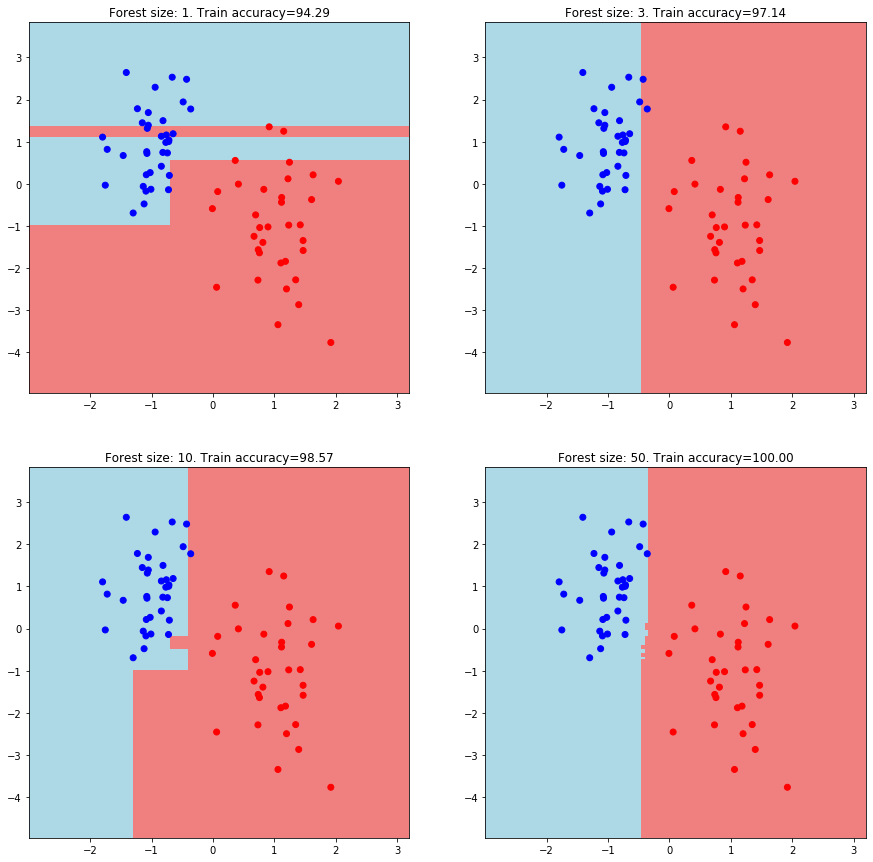

In [459]:
# Визуализируем тренировочные данные дерева на графике
rows = n // 2 + n % 2

fig, ax = plt.subplots(nrows=rows, ncols=2)
fig.set_size_inches(15, 15)
axf = ax.flatten()

i = 0
for i in range(n):
    mesh_predictions = np.array(tree_vote(my_forests[i], np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    axf[i].pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    axf[i].scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    axf[i].set_title(f'Forest size: {n_trees[i]}. Train accuracy={train_accuracy[i]:.2f}')

plt.show()

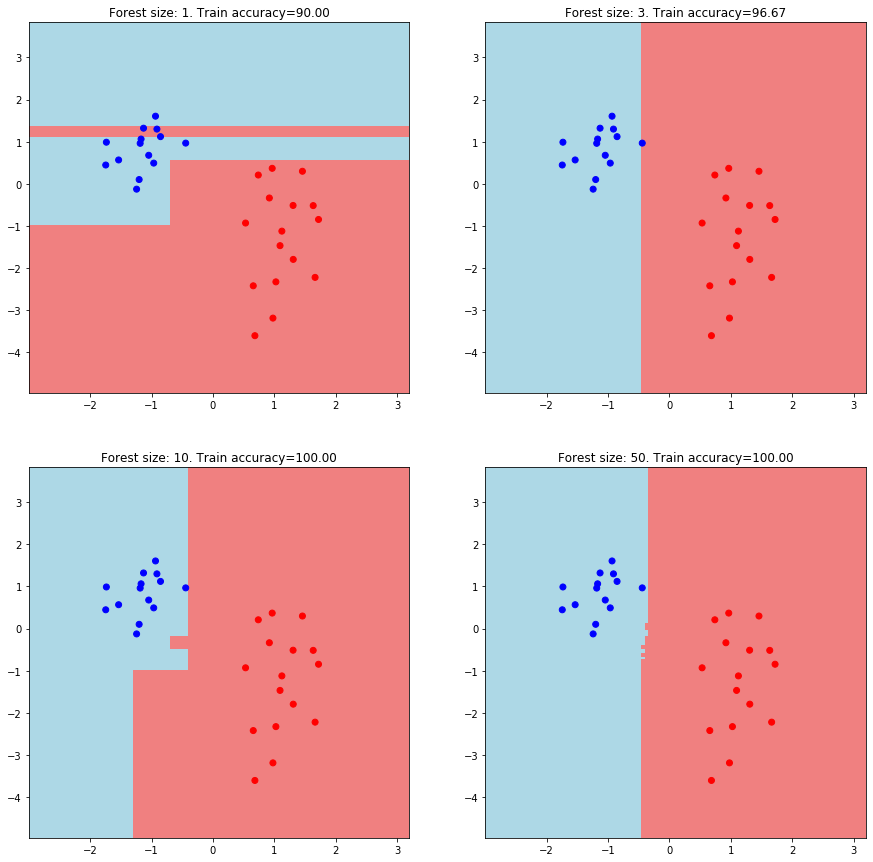

In [460]:
# Визуализируем тестовые данные дерева на графике
rows = n // 2 + n % 2

fig, ax = plt.subplots(nrows=rows, ncols=2)
fig.set_size_inches(15, 15)
axf = ax.flatten()

i = 0
for i in range(n):
    mesh_predictions = np.array(tree_vote(my_forests[i], np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    axf[i].pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    axf[i].scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    axf[i].set_title(f'Forest size: {n_trees[i]}. Train accuracy={test_accuracy[i]:.2f}')

plt.show()

### Сделаем выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

Данных для обучения мало и они разделяются на классы даже визуально. Поэтому даже одно дерево дает почти 100% точность. Но в то же время, оно переобучено, что показывает точность на тестовых данных.

3 дерева в случайном лесе уже дают 100% точность на тренировачных и валидационных данных, поэтому любое дальнейшее увеличение леса безсмысленно. Они будут переобучаться.

К тому же, т.к. у нас всего 100 наблюдений, то любая из этих моделей может оказаться переобученной на новых данных.

##  Задача 2

### Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

In [461]:
def get_oob_dataset(idx, data, labels):
    oob_test_data = np.delete(data, list(idx), axis=0)
    oob_test_labels = np.delete(labels, list(idx), axis=0)
#     print('Доля oob:', len(oob_test_data)/data.shape[0])
    
    return oob_test_data, oob_test_labels

In [462]:
def random_forest_oob(data, labels, n_trees):
    forests = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    oob_answer = []
    
    for b_data, b_labels, b_indexes in bootstrap:
        tree = build_tree(b_data, b_labels)
        forests.append(tree)
        
        oob_data, oob_labels = get_oob_dataset(b_indexes, b_data, labels)
        test_answers = predict(oob_data, tree)
        answers_dict = dict(zip(b_indexes, test_answers))
        oob_answer.append(answers_dict)
        
    return forests, oob_answer

In [475]:
n_trees = [1, 3, 10, 50]
n = len(n_trees)
my_forests = []
oob_answers = []
for t in n_trees:
    my_forest, oob_answer = random_forest_oob(classification_data, classification_labels, t)
    my_forests.append(my_forest)
    oob_answers.append(oob_answer)

In [476]:
res = []
for oob_answer in oob_answers:
    z = {}
    c = {}
    for answer_dict in oob_answer:
        for idx, label in answer_dict.items():
            if idx in z:
                z[idx].append(label)
            else:
                z[idx] = [label]
    res.append(z)

In [485]:
answ = []
for z in res:
    c = {}
    c = np.zeros([len(z), 2])
    i = 0
    for idx, lst in z.items():
        c[i, 0] = int(idx)
        c[i, 1] = round(np.sum(lst)/len(lst), 0)
        i += 1
    answ.append(c)

In [486]:
# Получим ответы для обучающей выборки 
train_answers = []

for i in range(n):
    train_answers.append(tree_vote(my_forests[i], classification_data))

In [487]:
# Получим ответы для обучающей выборки 
train_answers = []
test_answers = []
train_accuracy = []
for forest in my_forests:
    train_answers.append(tree_vote(forest, train_data))
    test_answers.append(tree_vote(forest, test_data))

In [488]:
# Точность на выборках:
train_accuracy = []
test_accuracy = []
for i in range(n):
    train_accuracy.append(accuracy_metric(train_labels, train_answers[i]))
    test_accuracy.append(accuracy_metric(classification_labels[answ[i][:, 0].astype(int)], answ[i][:, 1]))
    print(f'Точность случайного леса из {n_trees[i]} деревьев на обучающей выборке: {train_accuracy[i]:.3f}')
    print(f'Точность случайного леса из {n_trees[i]} деревьев на тестовой выборке: {test_accuracy[i]:.3f}')
    print('*'*60)

Точность случайного леса из 1 деревьев на обучающей выборке: 51.429
Точность случайного леса из 1 деревьев на тестовой выборке: 65.625
************************************************************
Точность случайного леса из 3 деревьев на обучающей выборке: 100.000
Точность случайного леса из 3 деревьев на тестовой выборке: 52.381
************************************************************
Точность случайного леса из 10 деревьев на обучающей выборке: 100.000
Точность случайного леса из 10 деревьев на тестовой выборке: 44.330
************************************************************
Точность случайного леса из 50 деревьев на обучающей выборке: 100.000
Точность случайного леса из 50 деревьев на тестовой выборке: 49.000
************************************************************


#### Возможно, что-то не то с моей реализацией OOB, поскольку с увеличением деревьев уменьшается accuracy

##  Задача 3

### Переписать функцию calc_gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в calc_entropy.

In [469]:
# Расчет энтропии Шеннона

def entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    entrp = 0
    delta = 1e-5
    for label in classes:
        p = classes[label] / len(labels)
        entrp += -p * np.log2((p + delta))
        
    return entrp

In [470]:
# Расчет качества через энтропию Шеннона

def quality(left_labels, right_labels, current_entropy):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_entropy - p * entropy(left_labels) - (1 - p) * entropy(right_labels)

Проверим работу энтропии:

In [471]:
n_trees = [1]
n = len(n_trees)
my_forests = []
b_idx = []
for t in n_trees:
    my_forest, b_indexes = random_forest(train_data, train_labels, t)
    my_forests.append(my_forest)
    b_idx.append(b_indexes)

In [472]:
# Получим ответы для обучающей выборки 
train_answers = []
test_answers = []
train_accuracy = []
for forest in my_forests:
    train_answers.append(tree_vote(forest, train_data))
    test_answers.append(tree_vote(forest, test_data))

In [473]:
# Точность на обучающей выборке
train_accuracy = []
test_accuracy = []
for i in range(n):
    train_accuracy.append(accuracy_metric(train_labels, train_answers[i]))
    test_accuracy.append(accuracy_metric(test_labels, test_answers[i]))
    print(f'Точность случайного леса из {n_trees[i]} деревьев на обучающей выборке: {train_accuracy[i]:.3f}')
    print(f'Точность случайного леса из {n_trees[i]} деревьев на тестовой выборке: {test_accuracy[i]:.3f}')
    print('*'*60)

Точность случайного леса из 1 деревьев на обучающей выборке: 48.571
Точность случайного леса из 1 деревьев на тестовой выборке: 53.333
************************************************************
